In [1]:
from federated_learning import Configuration
from federated_learning import LocalEnvironment

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torchvision import datasets, transforms
BATCH_SIZE = 128
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/mnist', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)

In [3]:
config = Configuration()
data = config.DATASET(config)
sim_env = LocalEnvironment(config, data)
sim_env.poison_clients()

MNIST training data loaded.
MNIST test data loaded.
Create Clients
1 clients poisoned
Label Flipping from 5 to 3


In [ ]:
# print(torch.where(sim_env.clients[0].train_dataloader.dataset.dataset.targets == 5, 3, sim_env.clients[0].train_dataloader.dataset.dataset.targets))

In [ ]:
sim_env.clients[0].net

In [4]:
sim_env.clients[0].test()
for epoch in range(1, config.N_EPOCHS + 1):
    sim_env.clients[0].train(epoch)
    sim_env.clients[0].test()


Test set: Avg. loss: 2.3040, Accuracy: 1012/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.293696
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.289249
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.299321
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.286887
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.268434
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.275722
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.273086
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.276573
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.234155
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.245923
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.242563
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.228072
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.197747
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.235689
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.199442
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.223118
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.187462
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.159768
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.104217
Train Epoch: 1 [12160

In [ ]:
import numpy as np
import shap
examples = enumerate(test_loader)
batch_idx, (images, example_targets) = next(examples)
first_index=[]
for i in range(10):
    try:
        index = torch.where(example_targets==i)
        first_index.append(index[0][-1].item())
    except: 
        print("does not exist")
print(first_index)

background = images[:50]
test_images = images[first_index]

e = shap.DeepExplainer(sim_env.clients[0].net, background)
shap_values = e.shap_values(test_images)

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i, idx in enumerate(first_index):
    plt.subplot(3,4,i+1)
    plt.tight_layout()
    plt.imshow(images[idx][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[idx]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [ ]:
output = sim_env.clients[0].net(images[first_index])
pred = output.data.max(1, keepdim=True)[1]
print(pred)

In [ ]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

In [ ]:
shap.image_plot(shap_numpy, -test_numpy)

In [14]:
import shap
import numpy as np
class SHAPUtils():
    def __init__(self, data_loader, net):
        self.data_loader = data_loader
        self.net = net
        self.images, self.targets = self.get_SHAP_dataset()
        self.shap_images, self.shap_indices = self.get_SHAP_sample()
        self.background = self.images[:50]
        self.e, self.shap_values = self.get_shap_values()
        self.prediction = self.predict_shap_images()
        
    def get_SHAP_dataset(self):
        examples = enumerate(self.data_loader)
        batch_idx, (self.images, self.targets) = next(examples)
        print(self.targets)
        return self.images, self.targets
        
    def get_SHAP_sample(self):
        indices=[]
        for i in range(10):
            try:
                index = torch.where(self.targets==i)
                indices.append(index[0][-1].item())
            except: 
                print("does not exist")
        return self.images[indices], indices
                    
    def get_shap_values(self):
        e = shap.DeepExplainer(self.net, self.background)
        shap_values = e.shap_values(self.shap_images)
        return e, shap_values

    
    def print_shap_images(self):
        fig = plt.figure()
        for i, idx in enumerate(self.shap_indices):
            plt.subplot(3,4,i+1)
            plt.tight_layout()
            plt.imshow(self.images[idx][0], cmap='gray', interpolation='none')
            plt.title("Ground Truth: {}".format(self.targets[idx]))
            plt.xticks([])
            plt.yticks([])
        plt.show()
        
    def predict_shap_images(self):
        output = self.net(self.images[self.shap_indices])
        pred = output.data.max(1, keepdim=True)[1]
        print(pred)
        return pred
    
    def plot(self):
        shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in self.shap_values]
        test_numpy = np.swapaxes(np.swapaxes(self.shap_images.numpy(), 1, -1), 1, 2)
        shap.image_plot(shap_numpy, -test_numpy)
    

tensor([[0],
        [1],
        [2],
        [3],
        [4],
        [4],
        [6],
        [7],
        [8],
        [9]])


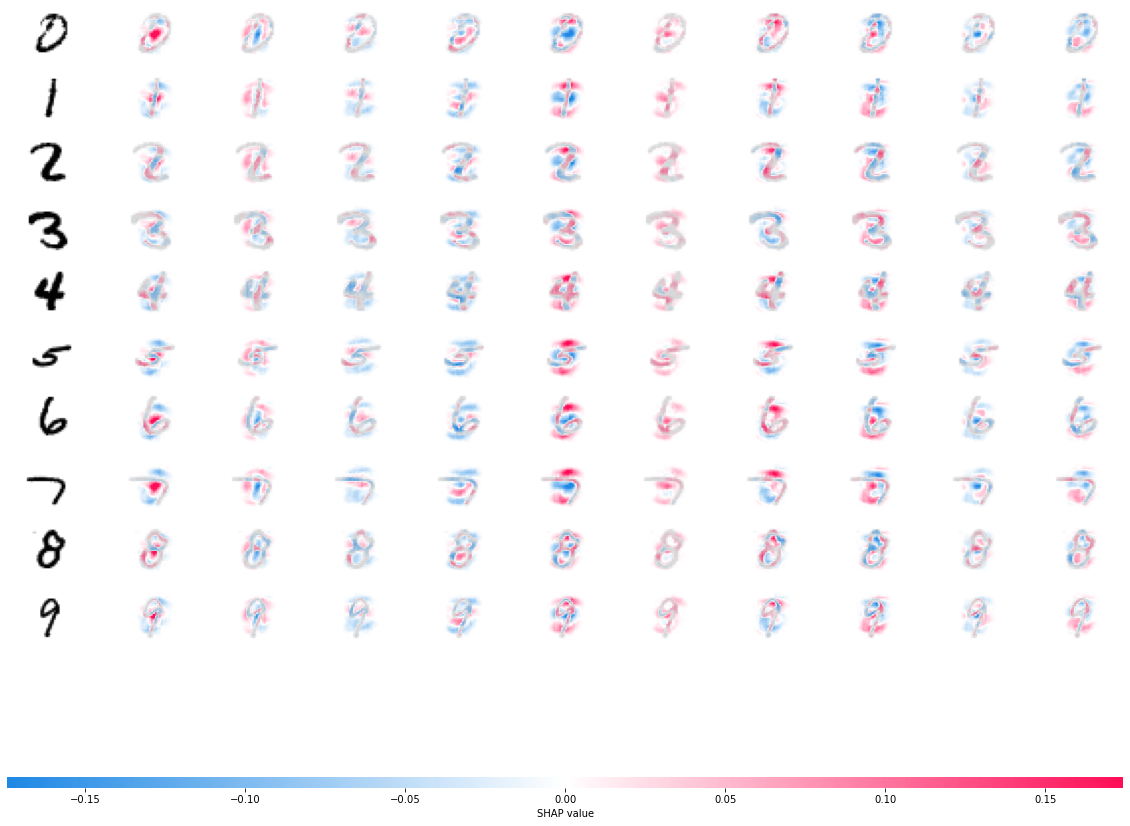

In [15]:
shap_util = SHAPUtils(test_loader, sim_env.clients[0].net)
shap_util.plot()